In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure, axis

import PIL
from PIL import Image
from skimage.transform import resize
import numpy as np
import tensorflow as tf

from nst_utils import *
from nst_costs import *

%matplotlib inline

In [2]:
"""
1. Load the content image & style image
2. Randomly initialize the image to be generated
3. Create an Interactive Session
4. Load the VGG16 model 
5. Build the TensorFlow graph: 
    - Run the content image through the VGG16 model and compute the content cost
    - Run the style image through the VGG16 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
6. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated
image at every step.
"""

# LOAD CONTENT & STYLE IMAGES
# requirement: (WIDTH = 300, HEIGHT = 225)
content_path = 'images/garou_resized.jpg'
content_image = scipy.misc.imread(content_path)
#content_image = resize(content_image, [300,225,3], PIL.Image.ANTIALIAS)
content_means = [np.mean(content_image[:,:,0]), np.mean(content_image[:,:,1]), np.mean(content_image[:,:,2])]
content_means = np.array(content_means).reshape((1,1,1,3))
style_path = 'images/dali_narciss_resized.jpg'
style_image = scipy.misc.imread(style_path)
#style_image = resize(style_image, [300,225,3], PIL.Image.ANTIALIAS)

[[-44.59207407 -43.59207407 -45.59207407 -39.59207407 -36.59207407]
 [-44.59207407 -47.59207407 -20.59207407 -24.59207407 -44.59207407]
 [-45.59207407 -32.59207407 -20.59207407 -31.59207407 -48.59207407]
 [-51.59207407 -20.59207407 -15.59207407 -50.59207407 -53.59207407]
 [-50.59207407 -20.59207407 -27.59207407 -48.59207407 -50.59207407]]


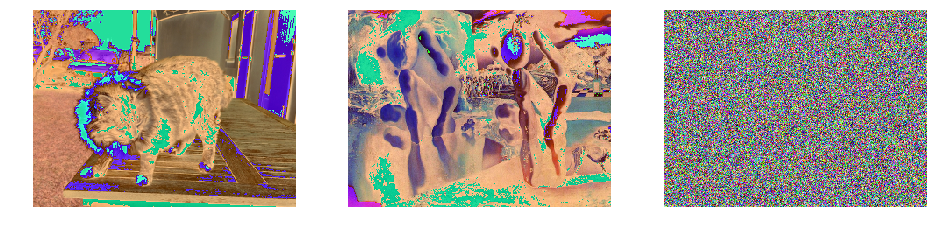

In [3]:
class CONFIG:
    IMAGE_HEIGHT = content_image.shape[0]
    IMAGE_WIDTH = content_image.shape[1]
    COLOR_CHANNELS = content_image.shape[2]
    NOISE_RATIO = 0.6
    MEANS = content_means
    #MEANS = np.array([np.mean(content_image[:,:,0]), np.mean(content_image[:,:,1]), 
    #                  np.mean(content_image[:,:,2])]).reshape((1,1,1,3)) 
    VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' 
    # Pick the VGG 19-layer model by from the paper "Very Deep  
    # Convolutional Networks for Large-Scale  Image Recognition".
    STYLE_IMAGE = style_path # Style image to use.
    CONTENT_IMAGE = content_path # Content image to use.
    OUTPUT_DIR = 'output/'

content_image = reshape_and_normalize_image(content_image,CONFIG)
print(content_image[0,0:5,0:5,1])
style_image = reshape_and_normalize_image(style_image,CONFIG)

# CREATES NEW IMAGE
generated_image = generate_noise_image(content_image,CONFIG)

fig = figure(figsize=(16, 8));
fig.add_subplot(1,3,1); imshow(content_image[0]); axis('off');
fig.add_subplot(1,3,2); imshow(style_image[0]); axis('off');
fig.add_subplot(1,3,3); imshow(generated_image[0]); axis('off');

In [4]:
# Reset the graph
tf.reset_default_graph()
# Start interactive session
sess = tf.InteractiveSession()

# http://www.vlfeat.org/matconvnet/pretrained/
# https://arxiv.org/abs/1508.06576
model = load_vgg_model(CONFIG)
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 225, 300, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 225, 300, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 225, 300, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 113, 150, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 113, 150, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 113, 150, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 57, 75, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 57, 75, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 57, 75, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 57, 75, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 57, 75, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 29, 38, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 29, 38, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1,

In [5]:
# CONTENT COST
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))
# Select the output tensor of layer conv4_2
out = model['conv4_2']
# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)
# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out
# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

# STYLE COST
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))
# Compute the style cost
J_style = compute_style_cost(sess, model, STYLE_LAYERS)

# TOTAL COST
CONTENT_COST_WEIGHT = 20
STYLE_COST_WEIGHT   = 20
J = total_cost(J_content, J_style, CONTENT_COST_WEIGHT, STYLE_COST_WEIGHT)

# DEFINE OPTIMIZER
# define optimizer
optimizer = tf.train.AdamOptimizer(1.0)
# define train_step
train_step = optimizer.minimize(J)

In [6]:
def model_nn(CONFIG, sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        _ = sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the CONFIG.OUTPUT_DIR directory
            save_image(CONFIG.OUTPUT_DIR + str(i) + ".png", generated_image, CONFIG)
    
    # save last generated image
    save_image(CONFIG.OUTPUT_DIR + 'generated_image.jpg', generated_image,CONFIG)
    
    return generated_image

Iteration 0 :
total cost = 5785029600.0
content cost = 8194.628
style cost = 289243300.0
Iteration 20 :
total cost = 1925151500.0
content cost = 12768.559
style cost = 96244810.0
Iteration 40 :
total cost = 795479940.0
content cost = 15652.806
style cost = 39758344.0
Iteration 60 :
total cost = 376205470.0
content cost = 16883.037
style cost = 18793390.0
Iteration 80 :
total cost = 229916270.0
content cost = 17692.213
style cost = 11478122.0


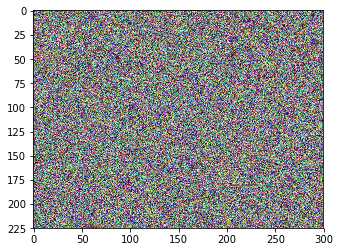

In [7]:
the_image = model_nn(CONFIG, sess, generated_image, 100)
the_image = the_image + CONFIG.MEANS
imshow(the_image[0])